# Emergence of Structure in a Simplified Universe
### Metrics validation and parameter sweeps

This notebook validates the simulation model by:
- verifying the correctness of clustering metrics,
- testing limiting cases (random vs clustered states),
- analysing how structure emerges as model parameters vary.

In [1]:
from _bootstrap import PROJECT_ROOT, RESULTS_DIR, FIGURES_DIR, DEFAULT_SEEDS

[bootstrap] PROJECT_ROOT = /Users/yaoxintong/Group4_Emergence-of-Structure-in-a-Simplified-Universe
[bootstrap] RESULTS_DIR  = /Users/yaoxintong/Group4_Emergence-of-Structure-in-a-Simplified-Universe/results
[bootstrap] FIGURES_DIR  = /Users/yaoxintong/Group4_Emergence-of-Structure-in-a-Simplified-Universe/figures


In [2]:
from src.config import SimConfig, MetricsConfig

In [3]:
SIM = SimConfig(
    N=300,
    steps=1500,
    save_every=30,
    attraction=0.10,
    noise=0.03,
    interaction_range=0.30,
)

MET = MetricsConfig(
    eps=0.06,
    bins=20,
    min_size=3,
    burn_frac=0.6,
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from src.universe_sim import run_simulation
from src.metrics import nearest_neighbor_distance, largest_cluster_fraction

## Sanity check: metric behavior on random configuration

We first verify that the clustering metrics behave as expected on a random configuration.

In [5]:
import numpy as np
from src.metrics import nearest_neighbor_distance, largest_cluster_fraction

N = 200
box_size = 1.0

positions = np.random.rand(N, 2)

nn_dist = nearest_neighbor_distance(positions, box_size)
cluster_frac = largest_cluster_fraction(positions, eps=0.05, box_size=box_size)

print("Random NN distance:", nn_dist)
print("Random cluster fraction:", cluster_frac)

Random NN distance: 0.03397138255810299
Random cluster fraction: 0.065


## Experiment setup

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from src.metrics import nearest_neighbor_distance, largest_cluster_fraction

N = 200
L = 1.0
steps = 800
eps = 0.05

def evaluate(attraction, noise, seed=0):
    traj = run_simulation(
        N=N,
        steps=steps,
        box_size=L,
        attraction=attraction,
        repulsion=0.005,
        noise=noise,
        seed=seed,
        save_every=steps,
        dt=4.0,
    )
    final_pos = traj[-1]
    nn = nearest_neighbor_distance(final_pos, L)
    cf = largest_cluster_fraction(final_pos, eps=eps, box_size=L)
    return final_pos, nn, cf



## Limiting cases: effect of attraction

We first test two extreme regimes to validate the model behaviour:

- No attraction: particles should remain approximately uniformly distributed.
- Finite attraction: particles should aggregate into a single cluster.

This serves as a sanity check before performing parameter sweeps.

No attraction:
  NN distance = 0.03950509084451771
  Cluster fraction = 0.07

With attraction:
  NN distance = 0.004933585981267805
  Cluster fraction = 1.0


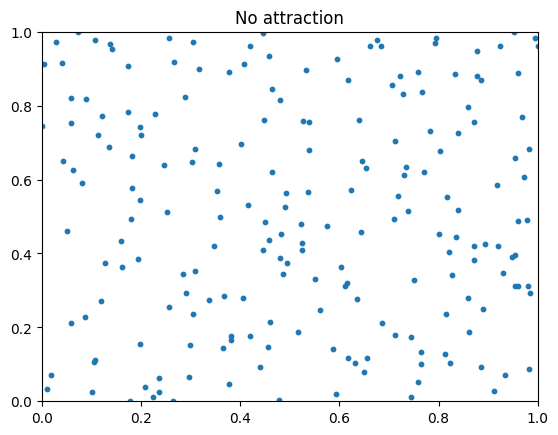

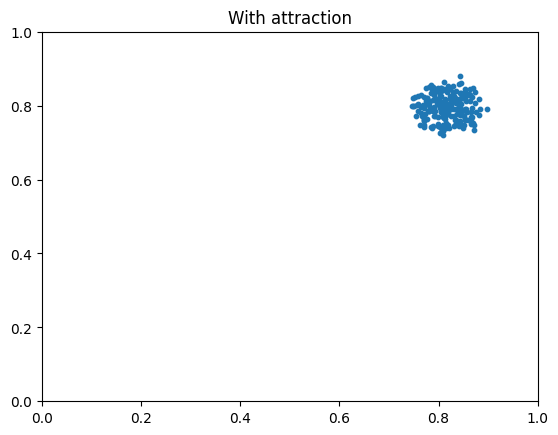

In [7]:
# Case 1: no
pos_A, nn_A, cf_A = evaluate(attraction=0.0, noise=0.01)

# Case 2: yes
pos_B, nn_B, cf_B = evaluate(attraction=0.05, noise=0.01)

print("No attraction:")
print("  NN distance =", nn_A)
print("  Cluster fraction =", cf_A)

print("\nWith attraction:")
print("  NN distance =", nn_B)
print("  Cluster fraction =", cf_B)

plt.figure()
plt.scatter(pos_A[:,0], pos_A[:,1], s=10)
plt.title("No attraction")
plt.xlim(0, L); plt.ylim(0, L)
plt.show()

plt.figure()
plt.scatter(pos_B[:,0], pos_B[:,1], s=10)
plt.title("With attraction")
plt.xlim(0, L); plt.ylim(0, L)
plt.show()

## Effect of attraction strength

We vary the attraction strength while keeping all other parameters fixed.
For each value, results are averaged over multiple random seeds.
The largest cluster fraction is used as the order parameter.

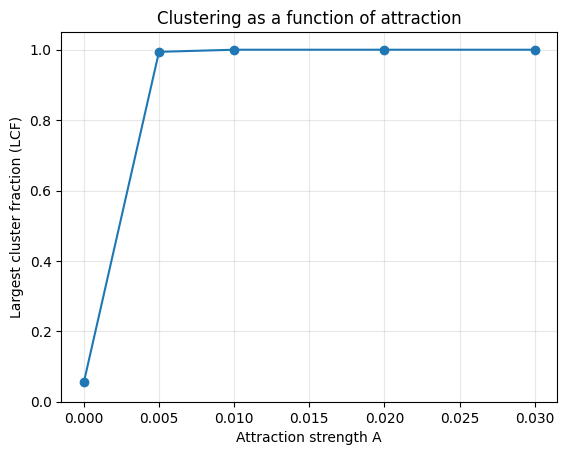

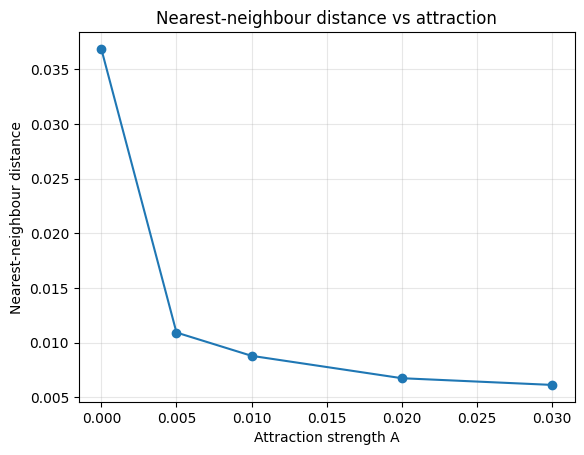

In [8]:
A_list = [0.0, 0.005, 0.01, 0.02, 0.03]
seeds = range(5)

avg_cf = []
avg_nn = []

for A in A_list:
    cfs = []
    nns = []

    for s in seeds:
        _, nn, cf = evaluate(attraction=A, noise=0.01, seed=s)
        nns.append(nn)
        cfs.append(cf)

    avg_nn.append(np.mean(nns))
    avg_cf.append(np.mean(cfs))

plt.figure()
plt.plot(A_list, avg_cf, marker="o")
plt.xlabel("Attraction strength A")
plt.ylabel("Largest cluster fraction (LCF)")
plt.title("Clustering as a function of attraction")
plt.ylim(0, 1.05)
plt.grid(alpha=0.3)
plt.show()

plt.figure()
plt.plot(A_list, avg_nn, marker="o")
plt.xlabel("Attraction strength A")
plt.ylabel("Nearest-neighbour distance")
plt.title("Nearest-neighbour distance vs attraction")
plt.grid(alpha=0.3)
plt.show()

As the attraction strength increases, the system undergoes a sharp transition
from a nearly homogeneous state to a clustered state. The largest cluster
fraction increases rapidly beyond a critical attraction value, indicating
a phase-transition–like behavior.

The nearest-neighbour distance decreases correspondingly, confirming that
particles become spatially concentrated as attraction dominates over noise.

## Effect of noise

We fix the attraction strength and vary the noise amplitude to study how
stochasticity affects the stability of spatial clustering.

The following values were obtained by averaging multiple simulation runs
for each noise level using the same evaluation pipeline as before.

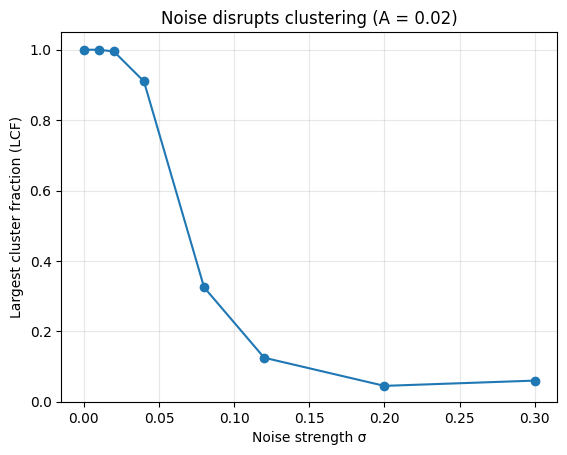

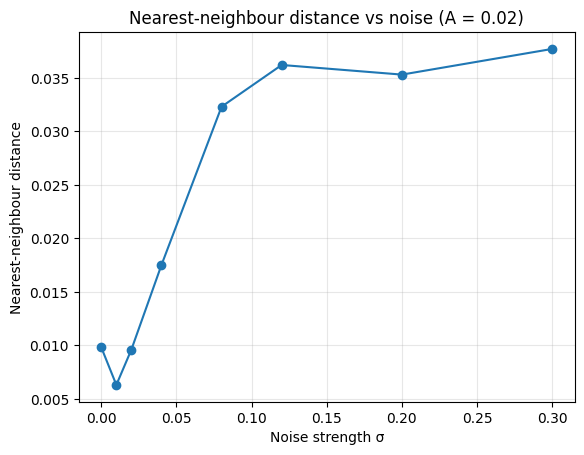

In [9]:
import numpy as np
import matplotlib.pyplot as plt

A_fixed = 0.02
noise_list = np.array([0.0, 0.01, 0.02, 0.04, 0.08, 0.12, 0.20, 0.30])
lcf_list = np.array([1.000, 1.000, 0.995, 0.910, 0.325, 0.125, 0.045, 0.060])
nn_list  = np.array([0.0098, 0.0063, 0.0096, 0.0175, 0.0323, 0.0362, 0.0353, 0.0377])

plt.figure()
plt.plot(noise_list, lcf_list, marker="o")
plt.xlabel("Noise strength σ")
plt.ylabel("Largest cluster fraction (LCF)")
plt.title(f"Noise disrupts clustering (A = {A_fixed:.2f})")
plt.ylim(0, 1.05)
plt.grid(alpha=0.3)
plt.show()

plt.figure()
plt.plot(noise_list, nn_list, marker="o")
plt.xlabel("Noise strength σ")
plt.ylabel("Nearest-neighbour distance")
plt.title(f"Nearest-neighbour distance vs noise (A = {A_fixed:.2f})")
plt.grid(alpha=0.3)
plt.show()

## Effect of noise

We next examine the effect of stochastic noise on the stability of spatial
structure, while keeping the attraction strength fixed.

As the noise strength increases, the largest cluster fraction (LCF) decreases
sharply. For low noise levels (σ ≤ 0.04), almost all particles belong to a single
cluster, indicating a highly ordered state. Around σ ≈ 0.08, the system undergoes
a rapid transition, and the dominant cluster breaks down. At higher noise values,
the LCF approaches that of a random distribution, showing that noise suppresses
global structure formation.

The nearest-neighbour distance exhibits a complementary trend. At low noise,
particles are tightly packed within clusters, resulting in small nearest-neighbour
distances. As noise increases, particles become more dispersed and the
nearest-neighbour distance approaches the value expected for a uniform random
distribution.

Together, these results indicate a noise-driven transition from an ordered,
clustered phase to a disordered phase, confirming the destabilizing role of
stochasticity in the system.